In [2]:
import pandas as pd
from print_info import column_info, rare_category_info, unique_categorical_values_info
from utils import open_json, haversine
from preprocessing import (
    replace_rare_categories,
    fill_missing_coordinates,
    find_nearest_neighbors,
    fill_missing_values,
    find_nearest_metro,
    label_encode_categorical,
    trim_df_by_quantiles,
    filter_outliers_with_isolation_forest
)
import datetime
from metro_info import get_metro_info_by_city, get_coordinates_by_city
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [3]:
columns_to_keep = [
    "id",
    "meta.district",
    "floors",
    "bedrooms_cnt",
    "euro",
    "mortgage",
    "wall_id",
    "rooms",
    "type",
    "floor",
    "balcon",
    "studio",
    "square",
    "building_year",
    "lo",
    "la",
    "price",
    "keep",
]


categorical = ["meta.district", "type", "balcon", "wall_id", "keep", "nearest_metro"]

bool_columns = [
    "is_object_rural_mortgage",
    "auction_object",
    "debt_transfer",
    "euro",
    "mortgage",
    "docs_to_deals",
    "young_family",
    "studio",
    "transport",
]

In [4]:
file_paths = ['spb.json']
city = "Санкт-Петербург"
dfs = [open_json(file_path) for file_path in file_paths]

common_columns = set.intersection(*[set(df.columns) for df in dfs])

merged_df = pd.concat([df[list(common_columns)] for df in dfs], ignore_index=True)

In [5]:
column_info(merged_df)

Информация о колонках:
Колонка 'premium_status_phone': количество уникальных значений = 1, тип данных = object, количество NaN = 4963
Колонка 'floors': количество уникальных значений = 34, тип данных = int64, количество NaN = 0
Колонка 'status': количество уникальных значений = 1, тип данных = object, количество NaN = 0
Колонка 'bedrooms_cnt': количество уникальных значений = 20, тип данных = int64, количество NaN = 0
Колонка 'debt_transfer': количество уникальных значений = 2, тип данных = bool, количество NaN = 0
Колонка 'current_mortgage_rate': количество уникальных значений = 21, тип данных = object, количество NaN = 4930
Колонка 'price_m2': количество уникальных значений = 4373, тип данных = object, количество NaN = 0
Колонка 'main_photo': количество уникальных значений = 4912, тип данных = object, количество NaN = 49
Колонка 'online_showing': количество уникальных значений = 2, тип данных = bool, количество NaN = 0
Колонка 'photo_url': количество уникальных значений = 325, тип да

In [6]:
dfs_filtered = [df.loc[:, columns_to_keep] for df in dfs]

In [7]:
dfs_filtered[0]

,id,meta.district,floors,bedrooms_cnt,euro,mortgage,wall_id,rooms,type,floor,balcon,studio,square,building_year,lo,la,price,keep
0,9228724,Шушары п,5,1,False,True,15.0,1,flat,4,no_balcon,False,39.9,2010,30.460443,59.733931,6250000,good
1,10172251,Выборгский,13,2,False,True,15.0,2,flat,12,yes_balcon,False,54.21,2022,30.328049,59.99026,14700000,good
2,9591147,Невский,15,6,False,False,11.0,6,room,4,yes_balcon,False,12,1979,30.453948,59.915224,1850000,cosmetic
3,10298633,Шушары п,25,1,False,True,65.0,1,flat,20,balcon,False,37.1,2017,30.367872,59.810093,6450000,good
4,10581495,Выборгский,25,1,False,True,11.0,1,flat,6,loggia,False,41,2015,30.335074,60.027741,11500000,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,10741706,Василеостровский,5,1,False,True,11.0,1,flat,1,yes_balcon,True,19.3,None,30.261178,59.939466,6000000,good
4959,10738564,Московский,12,1,False,True,65.0,1,flat,6,yes_balcon,False,24.6,None,30.323073,59.852176,12499000,design
4960,10735564,Приморский,25,1,False,True,65.0,1,flat,1,yes_balcon,False,33.3,2019,30.227968,60.039081,6900000,cosmetic
4961,10737767,Мурино,20,2,False,True,65.0,2,flat,4,yes_balcon,False,52,2018,30.423468,60.060038,8200000,good


In [8]:
merged_df = pd.concat([df for df in dfs_filtered], ignore_index=True)

In [9]:
column_info(merged_df)

Информация о колонках:
Колонка 'id': количество уникальных значений = 4963, тип данных = int64, количество NaN = 0
Колонка 'meta.district': количество уникальных значений = 136, тип данных = object, количество NaN = 0
Колонка 'floors': количество уникальных значений = 34, тип данных = int64, количество NaN = 0
Колонка 'bedrooms_cnt': количество уникальных значений = 20, тип данных = int64, количество NaN = 0
Колонка 'euro': количество уникальных значений = 2, тип данных = bool, количество NaN = 0
Колонка 'mortgage': количество уникальных значений = 2, тип данных = bool, количество NaN = 0
Колонка 'wall_id': количество уникальных значений = 11, тип данных = float64, количество NaN = 1
Колонка 'rooms': количество уникальных значений = 19, тип данных = int64, количество NaN = 0
Колонка 'type': количество уникальных значений = 4, тип данных = object, количество NaN = 0
Колонка 'floor': количество уникальных значений = 30, тип данных = int64, количество NaN = 0
Колонка 'balcon': количество 

In [10]:
merged_df.dtypes

id                 int64
meta.district     object
floors             int64
bedrooms_cnt       int64
euro                bool
mortgage            bool
wall_id          float64
rooms              int64
type              object
floor              int64
balcon            object
studio              bool
square            object
building_year     object
lo                object
la                object
price             object
keep              object
dtype: object

In [11]:
merged_df["lo"] = merged_df["lo"].astype(float)
merged_df["la"] = merged_df["la"].astype(float)
merged_df["price"] = merged_df["price"].astype(float)
merged_df["square"] = merged_df["square"].astype(float)

In [12]:
print("Редко встречающиеся районы:")
rare_category_info(merged_df, 'meta.district', rare_threshold=10)

Редко встречающиеся районы:
Свердлова им. пос: 9
Усть-Славянка: 8
Кронштадт: 8
Металлострой п: 8
Малое Верево д: 8
Стрельна пос: 7
Песочный п: 7
Старая д: 7
Тельмана пос: 5
Никольское г: 5
Кировск г: 5
Сосновый Бор г: 5
Курортный: 4
Романовка д: 4
Малое Карлино дер: 4
Тосно г: 4
Скотное д: 3
Горелово: 3
Тельмановское СП: 3
Кузьмоловский пос: 3
Сиверский ГП: 3
Город Первых ЖК: 3
Шлиссельбург г: 3
Павловск г: 3
Красный Бор пос: 2
Рахья п: 2
Заневка д: 2
Щеглово п: 2
Новый Учхоз п: 2
Лаголово дер: 2
Кингисепп г: 2
Елизаветино п: 2
Зеленогорск г: 2
Дубровка ГП: 2
Павлово г: 2
Кронштадтский: 2
Луга г: 2
Рощино пос: 2
Оредеж п: 2
Пудомяги д: 2
Янино-1: 2
Коломяги муниципальный округ: 2
Фёдоровское пос: 2
Большой Сабск д: 1
Гостицы дер: 1
Дубровка п: 1
Павлово с: 1
Серебрянский п: 1
Кудрово г: 1
Левашово п: 1
Мистолово д: 1
Ленинское пос: 1
Шум с: 1
Касимово д: 1
Молодежное пос: 1
Почап д: 1
Бегуницы д: 1
Лукаши п: 1
Аннино пос: 1
Ермилово пос: 1
Большие Колпаны д: 1
Коммунары пос: 1
Коркино 

In [13]:
merged_df = replace_rare_categories(merged_df, 'meta.district', 10)

In [14]:
merged_df['meta.district'].value_counts().get('Other', 0)

0

In [15]:
mask = (merged_df['meta.district'] == 'Other')

In [16]:
print("Количество пропущенных значений в столбце 'lo' для объектов с meta.district == 'Other':", merged_df.loc[mask, 'lo'].isna().sum())
print("Количество пропущенных значений в столбце 'la' для объектов с meta.district == 'Other':", merged_df.loc[mask, 'la'].isna().sum())

Количество пропущенных значений в столбце 'lo' для объектов с meta.district == 'Other': 0
Количество пропущенных значений в столбце 'la' для объектов с meta.district == 'Other': 0


In [17]:
merged_df = merged_df[~(mask & (merged_df['lo'].isna() | merged_df['la'].isna()))].reset_index(drop=True)

In [18]:
print("Количество пропущенных значений в столбце 'lo' для объектов с meta.district == 'Other':", merged_df.loc[mask, 'lo'].isna().sum())
print("Количество пропущенных значений в столбце 'la' для объектов с meta.district == 'Other':", merged_df.loc[mask, 'la'].isna().sum())

Количество пропущенных значений в столбце 'lo' для объектов с meta.district == 'Other': 0
Количество пропущенных значений в столбце 'la' для объектов с meta.district == 'Other': 0


In [19]:
#TODO Заменить Other на первый ближайший meta.district

In [20]:
print(merged_df.shape)
merged_df[['meta.district', 'la', 'lo']].isnull().sum()

(4963, 18)


meta.district      0
la               139
lo               139
dtype: int64

In [21]:
merged_df = fill_missing_coordinates(merged_df, 'meta.district', 'la', 'lo')
merged_df[['meta.district', 'la', 'lo']].isnull().sum()

meta.district    0
la               0
lo               0
dtype: int64

In [22]:
merged_df = find_nearest_neighbors(merged_df, 'la', 'lo', n_neighbors=11)
merged_df['nearest_neighbors_haversine_no_self']

0       [65, 343, 476, 1079, 1703, 3858, 3895, 3960, 4...
1       [167, 1217, 1218, 1236, 1387, 1956, 2317, 2337...
2       [471, 1067, 1499, 1705, 1964, 2293, 2410, 3224...
3       [722, 923, 1393, 1403, 1777, 2501, 3160, 3404,...
4       [187, 2166, 2197, 2843, 3172, 3173, 3182, 3575...
                              ...                        
4958    [760, 799, 954, 1230, 1278, 1441, 1457, 1517, ...
4959    [375, 439, 474, 833, 1070, 1258, 1401, 1531, 1...
4960    [575, 1505, 1682, 1896, 2315, 2809, 3475, 3674...
4961    [856, 2207, 2219, 2415, 3400, 3724, 3743, 4679...
4962    [856, 1776, 2171, 2219, 2415, 3400, 3724, 3743...
Name: nearest_neighbors_haversine_no_self, Length: 4963, dtype: object

In [23]:
merged_df['building_year'] = merged_df.apply(lambda row: fill_missing_values(merged_df, row, row['nearest_neighbors_haversine_no_self'], 'building_year'), axis=1)
merged_df['wall_id'] = merged_df.apply(lambda row: fill_missing_values(merged_df, row, row['nearest_neighbors_haversine_no_self'], 'wall_id'), axis=1)
merged_df['keep'] = merged_df.apply(lambda row: fill_missing_values(merged_df, row, row['nearest_neighbors_haversine_no_self'], 'keep'), axis=1)

In [24]:
merged_df[['building_year', 'wall_id', 'keep']].isna().sum()

building_year    0
wall_id          0
keep             0
dtype: int64

In [25]:
metro = get_metro_info_by_city("Санкт-Петербург")
merged_df['nearest_metro'], merged_df['dist_to_metro'] = zip(*merged_df.apply(lambda row: find_nearest_metro(row['la'], row['lo'], metro), axis=1))

In [26]:
la_centre, lo_centre = get_coordinates_by_city("Санкт-Петербург")
merged_df['distance_to_centre'] = merged_df.apply(lambda row: haversine(la_centre, lo_centre, row['la'], row['lo']), axis=1)

In [27]:
merged_df[['nearest_metro', 'dist_to_metro', 'distance_to_centre', 'price']]

,nearest_metro,dist_to_metro,distance_to_centre,price
0,Шушары,9.694897,24.182404,6250000.0
1,Лесная,1.087557,5.796556,14700000.0
2,Проспект Большевиков,0.854981,8.214455,1850000.0
3,Купчино,2.191244,14.601042,6450000.0
4,Озерки,1.274783,9.980453,11500000.0
...,...,...,...,...
4958,Василеостровская,0.998728,2.949322,6000000.0
4959,Московская,0.068082,9.622932,12499000.0
4960,Комендантский проспект,3.819400,12.156590,6900000.0
4961,Девяткино,1.503802,14.809244,8200000.0


In [28]:
merged_df.isna().sum()

id                                     0
meta.district                          0
floors                                 0
bedrooms_cnt                           0
euro                                   0
mortgage                               0
wall_id                                0
rooms                                  0
type                                   0
floor                                  0
balcon                                 0
studio                                 0
square                                 0
building_year                          0
lo                                     0
la                                     0
price                                  0
keep                                   0
nearest_neighbors_haversine_no_self    0
nearest_metro                          0
dist_to_metro                          0
distance_to_centre                     0
dtype: int64

In [29]:
merged_df['building_year'] = datetime.datetime.now().year - merged_df['building_year'].astype(int)
merged_df['wall_id'] = merged_df['wall_id'].astype(int).astype(str)
merged_df['meta.district'] = merged_df['meta.district'].astype(str)

In [30]:
merged_df.drop(['lo', 'la', 'id', 'nearest_neighbors_haversine_no_self'], axis=1, inplace=True)

In [31]:
merged_df[categorical] = merged_df[categorical].astype('category')

In [32]:
merged_df_trimmed = trim_df_by_quantiles(merged_df, "price")
(merged_df_trimmed.shape, merged_df.shape)

((4462, 18), (4963, 18))

In [33]:
merged_df_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4462 entries, 0 to 4962
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   meta.district       4462 non-null   category
 1   floors              4462 non-null   int64   
 2   bedrooms_cnt        4462 non-null   int64   
 3   euro                4462 non-null   bool    
 4   mortgage            4462 non-null   bool    
 5   wall_id             4462 non-null   category
 6   rooms               4462 non-null   int64   
 7   type                4462 non-null   category
 8   floor               4462 non-null   int64   
 9   balcon              4462 non-null   category
 10  studio              4462 non-null   bool    
 11  square              4462 non-null   float64 
 12  building_year       4462 non-null   int64   
 13  price               4462 non-null   float64 
 14  keep                4462 non-null   category
 15  nearest_metro       4462 non-null   categor

In [34]:
unique_categorical_values_info(merged_df_trimmed)  

Уникальные значения в столбце meta.district: ['Шушары п', 'Выборгский', 'Приморский', 'Кудрово', 'Невский', 'Мурино', 'Центральный', 'Адмиралтейский', 'Московский', 'Кировский', 'Всеволожск г', 'Фрунзенский', 'Красногвардейский', '10', 'Василеостровский', 'Новое Девяткино д', 'Пушкинский', 'Красносельский', 'Петроградский', 'Янино-1 п', 'Калининский', 'Петергоф г', 'Бугры п', 'Пушкин г', 'Сертолово', 'Сестрорецк г', 'Парголово п', 'Новосаратовка д', 'Коммунар г', 'Петродворцовый', 'Ломоносов г', 'Всеволожский', 'Гатчина г', 'Новоселье пос', 'Колпино г', 'Красное Село', 'Новогорелово пос', 'Выборг г']
Уникальные значения в столбце wall_id: ['15', '65', '11', '12', '64', '14', '457', '66', '16', '85']
Уникальные значения в столбце type: ['flat', 'apart', 'room']
Уникальные значения в столбце balcon: ['no_balcon', 'yes_balcon', 'balcon', 'loggia', 'more_balcon', 'terrace', 'more_loggia', 'balcon_loggia', 'erker']
Уникальные значения в столбце keep: ['good', 'design', 'black', 'cosmetic', 

In [35]:
from sklearn.preprocessing import LabelEncoder
non_categorical_columns = merged_df_trimmed.columns.difference(categorical)
isolation_df = merged_df_trimmed[non_categorical_columns].copy()
for column in categorical:
    label_encoder = LabelEncoder()
    isolation_df[column] = label_encoder.fit_transform(merged_df_trimmed[column])

meta.district
type
balcon
wall_id
keep
nearest_metro


In [36]:
isolation_df.dtypes

bedrooms_cnt            int64
building_year           int64
dist_to_metro         float64
distance_to_centre    float64
euro                     bool
floor                   int64
floors                  int64
mortgage                 bool
price                 float64
rooms                   int64
square                float64
studio                   bool
meta.district           int64
type                    int64
balcon                  int64
wall_id                 int64
keep                    int64
nearest_metro           int64
dtype: object

In [37]:
isolation_df

,bedrooms_cnt,building_year,dist_to_metro,distance_to_centre,euro,floor,floors,mortgage,price,rooms,square,studio,meta.district,type,balcon,wall_id,keep,nearest_metro
0,1,14,9.694897,24.182404,False,4,5,True,6250000.0,1,39.90,False,36,1,6,3,3,64
1,2,2,1.087557,5.796556,False,12,13,True,14700000.0,2,54.21,False,7,1,8,3,3,25
3,1,7,2.191244,14.601042,False,20,25,True,6450000.0,1,37.10,False,36,1,0,7,3,22
4,1,9,1.274783,9.980453,False,6,25,True,11500000.0,1,41.00,False,7,1,3,0,3,36
5,1,4,0.660377,7.050941,False,8,13,True,6200000.0,1,23.50,True,29,0,8,7,2,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,1,121,0.998728,2.949322,False,1,5,True,6000000.0,1,19.30,True,3,1,8,0,3,6
4959,1,1,0.068082,9.622932,False,6,12,True,12499000.0,1,24.60,False,18,1,8,7,2,30
4960,1,5,3.819400,12.156590,False,1,25,True,6900000.0,1,33.30,False,29,1,8,7,1,21
4961,2,6,1.503802,14.809244,False,4,20,True,8200000.0,2,52.00,False,19,1,8,7,3,13


In [38]:
filtered_df = filter_outliers_with_isolation_forest(isolation_df)

In [39]:
filtered_df

,bedrooms_cnt,building_year,dist_to_metro,distance_to_centre,euro,floor,floors,mortgage,price,rooms,square,studio,meta.district,type,balcon,wall_id,keep,nearest_metro
0,1,14,9.694897,24.182404,False,4,5,True,6250000.0,1,39.90,False,36,1,6,3,3,64
1,2,2,1.087557,5.796556,False,12,13,True,14700000.0,2,54.21,False,7,1,8,3,3,25
4,1,9,1.274783,9.980453,False,6,25,True,11500000.0,1,41.00,False,7,1,3,0,3,36
5,1,4,0.660377,7.050941,False,8,13,True,6200000.0,1,23.50,True,29,0,8,7,2,56
7,1,0,2.284037,11.595765,False,3,12,True,7000000.0,1,35.70,False,16,1,8,7,1,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,1,121,0.998728,2.949322,False,1,5,True,6000000.0,1,19.30,True,3,1,8,0,3,6
4959,1,1,0.068082,9.622932,False,6,12,True,12499000.0,1,24.60,False,18,1,8,7,2,30
4960,1,5,3.819400,12.156590,False,1,25,True,6900000.0,1,33.30,False,29,1,8,7,1,21
4961,2,6,1.503802,14.809244,False,4,20,True,8200000.0,2,52.00,False,19,1,8,7,3,13


In [40]:
y = filtered_df['price']
x = filtered_df.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [41]:
model = CatBoostRegressor(cat_features=categorical, verbose=100, nan_mode="Min", iterations=1000)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.060582
0:	learn: 3483452.0668044	test: 3266571.7180899	best: 3266571.7180899 (0)	total: 54.8ms	remaining: 54.8s
100:	learn: 1394791.7356109	test: 1445616.1311391	best: 1445616.1311391 (100)	total: 217ms	remaining: 1.93s
200:	learn: 1245623.7358118	test: 1390697.1326577	best: 1390697.1326577 (200)	total: 384ms	remaining: 1.52s
300:	learn: 1147000.2355531	test: 1370980.2117602	best: 1370980.2117602 (300)	total: 710ms	remaining: 1.66s
400:	learn: 1077060.5677683	test: 1365995.2698105	best: 1363183.9575818 (347)	total: 883ms	remaining: 1.32s
500:	learn: 1012105.6610168	test: 1362185.3634209	best: 1361800.1377949 (440)	total: 1.06s	remaining: 1.06s
600:	learn: 963174.0186816	test: 1355898.1039289	best: 1355503.1881918 (587)	total: 1.39s	remaining: 926ms
700:	learn: 917474.1225057	test: 1355195.3617828	best: 1354717.1261663 (651)	total: 1.88s	remaining: 806ms
800:	learn: 881500.8658571	test: 1354448.3622988	best: 1352817.0201777 (748)	total: 2.37s	remaining: 592ms
900:

In [42]:
import shap
explainer = shap.TreeExplainer(model)

In [43]:
shap_values = explainer.shap_values(X_test)

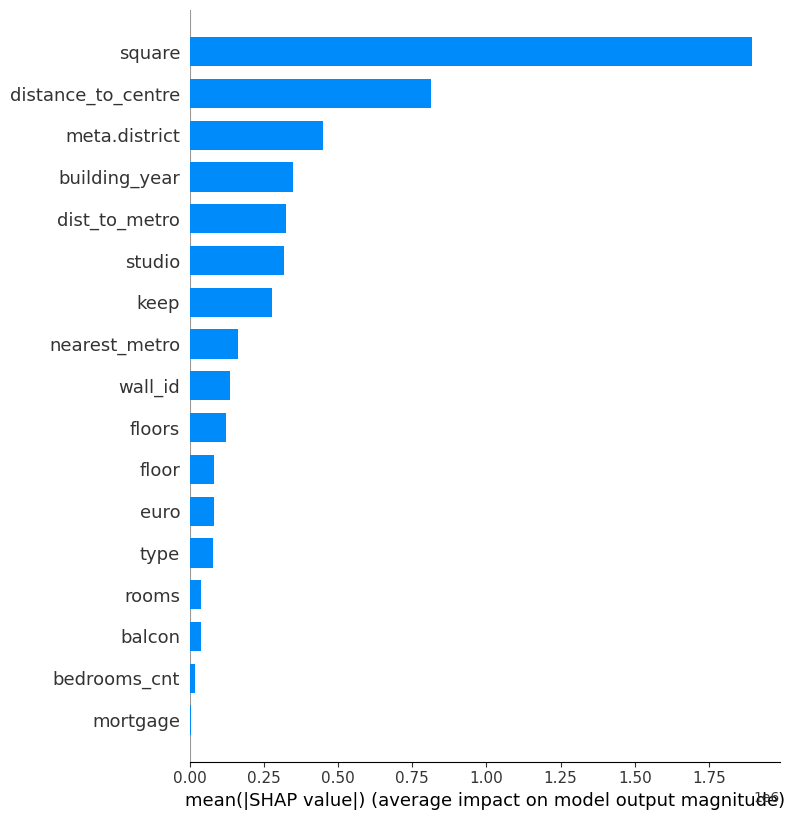

In [44]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

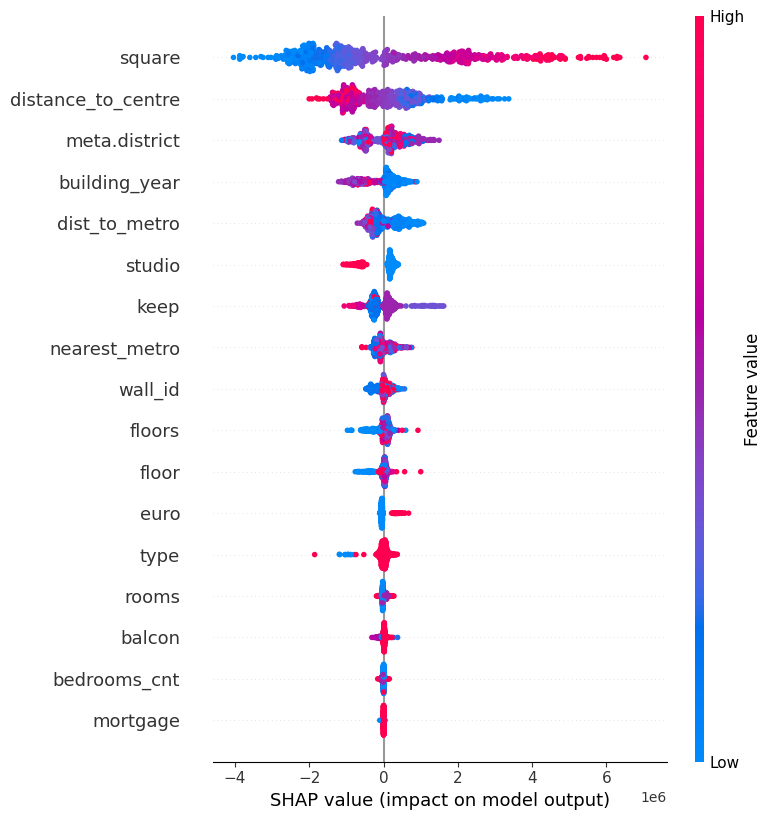

In [45]:
shap.summary_plot(shap_values, X_test)

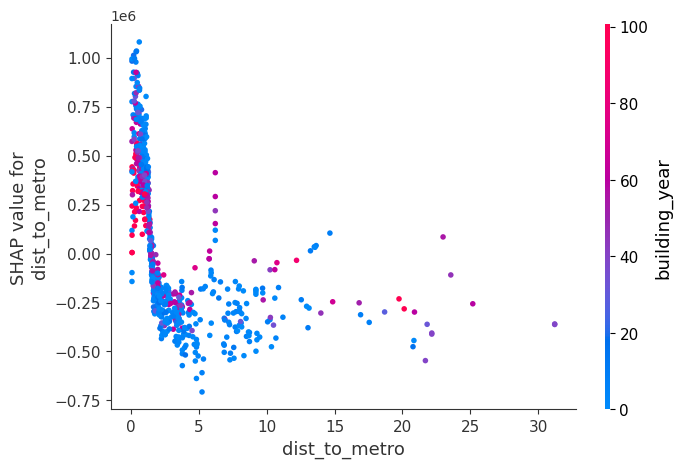

In [46]:
shap.dependence_plot("dist_to_metro", shap_values, X_test)

In [47]:
num = 2
print(y_test.iloc[num])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[num], X_test.iloc[num])

11300000.0


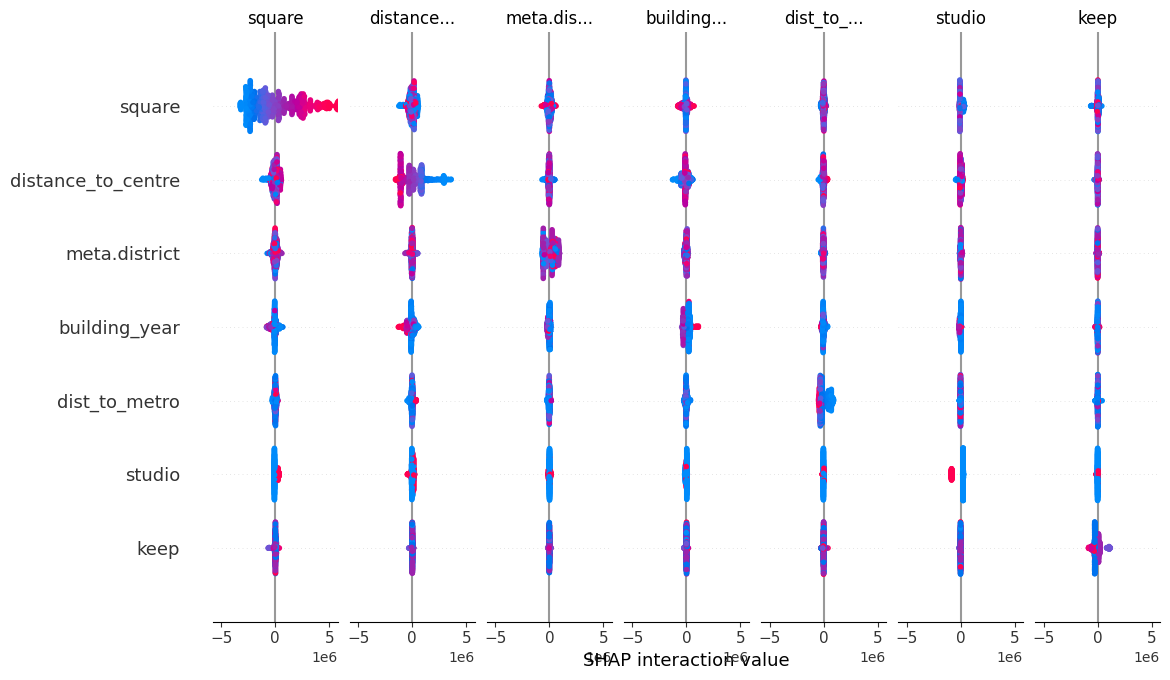

In [49]:
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test)

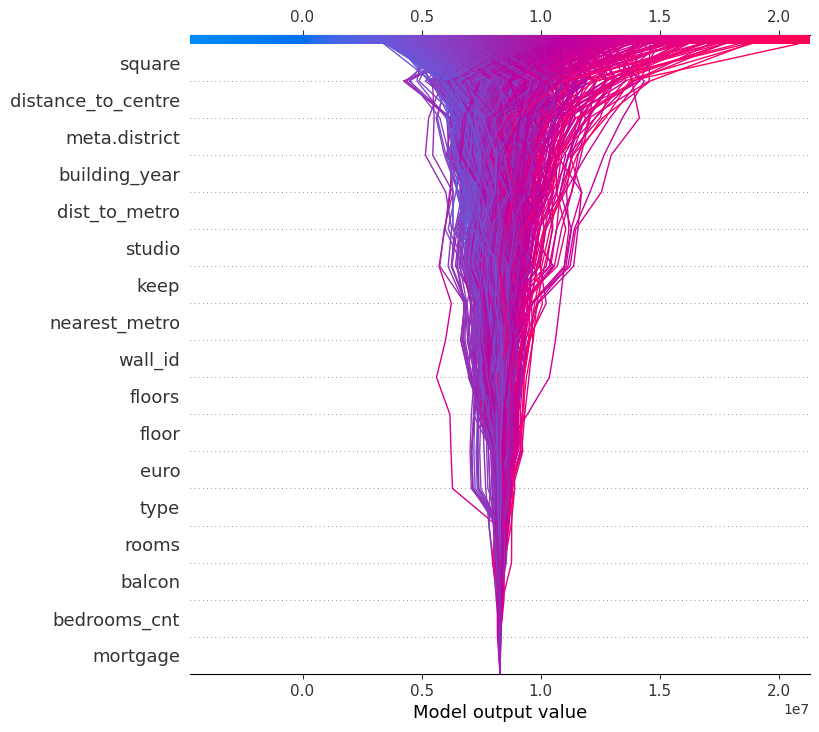

In [50]:
shap.decision_plot(explainer.expected_value, shap_values, X_test)